In [87]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from roboflow import Roboflow
import numpy as np
import pandas as pd
import supervision as sv

In [88]:
rf = Roboflow(api_key="LVSHEOlTJ8VX1dSnqMLM")
project = rf.workspace().project("sokak-kopekleri")
model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


In [89]:
def find_coordinates(image_path,trust):
    coordinates = model.predict(image_path, confidence= trust*100, overlap=30).json()
    return coordinates
find_coordinates("Med1.jpg", 0.6)

{'predictions': [{'x': 3323,
   'y': 2204,
   'width': 195,
   'height': 231,
   'confidence': 0.8286110162734985,
   'class': 'dog',
   'class_id': 0,
   'detection_id': '942633db-ca33-4f22-904a-97827656e433',
   'image_path': 'Med1.jpg',
   'prediction_type': 'ObjectDetectionModel'}],
 'image': {'width': '4032', 'height': '3024'}}

In [90]:
def predicted_values(coordinates):
    desired_outputs = [{key: prediction[key] for key in ['x', 'y', 'width', 'height', 'confidence']}
    for prediction in coordinates['predictions']]
    
    return desired_outputs
print(predicted_values(find_coordinates("Med1.jpg",0.5)))

[{'x': 3323, 'y': 2204, 'width': 195, 'height': 231, 'confidence': 0.8286110162734985}]


In [91]:
def visualize(image_path, trust):
    image = Image.open(image_path)
    predictions = predicted_values(find_coordinates(image_path, trust))
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for pred in predictions:
        center_x, center_y, width, height, confidence = pred['x'], pred['y'], pred['width'], pred['height'], pred['confidence']
        top_left_x = center_x - (width / 2)
        top_left_y = center_y - (height / 2)
        rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=1, edgecolor='r', facecolor='none', label=f'Confidence: {confidence:.2f}')
        ax.add_patch(rect)
        plt.text(top_left_x, top_left_y, f'{confidence:.2f}', color='white', fontsize=6, backgroundcolor='red')

    plt.show()

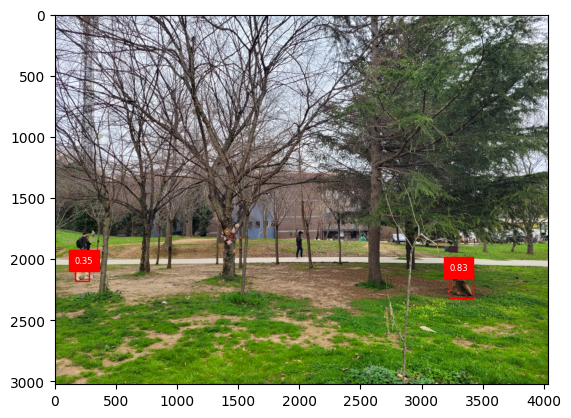

In [92]:
visualize("Med1.jpg", 0.3)

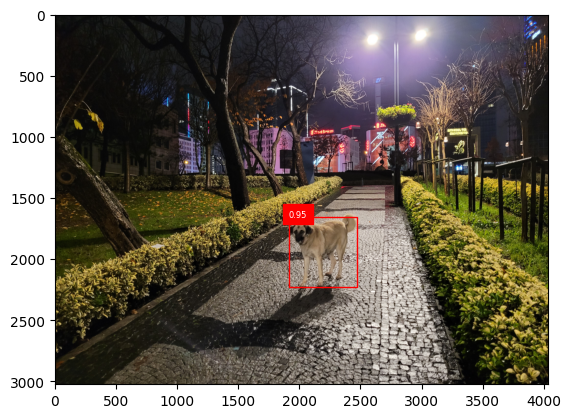

In [93]:
visualize("Arı_Kapı1.jpg", 0.75)

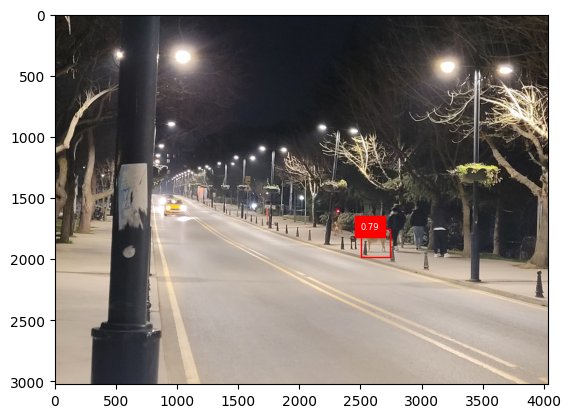

In [94]:
visualize("Merkez_Dört_yol1.jpg", 0.75)

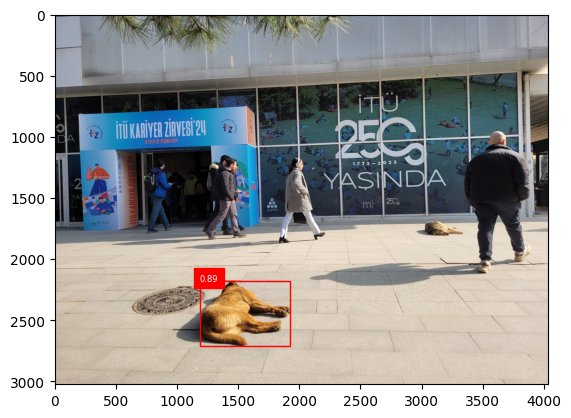

In [95]:
visualize("MED3.jpg", 0.75)

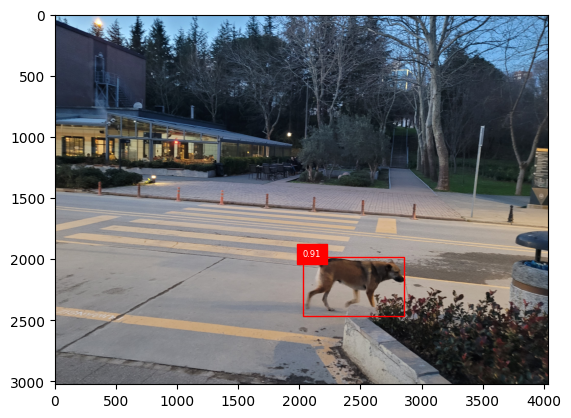

In [96]:
visualize("Merkez_Dört_yol2.jpg", 0.75)

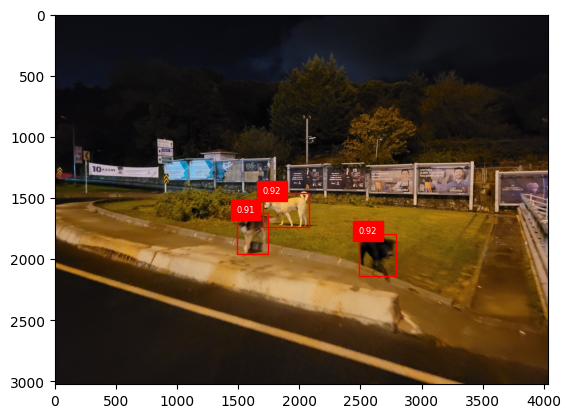

In [97]:
visualize("Kütüphane3.jpg", 0.75)

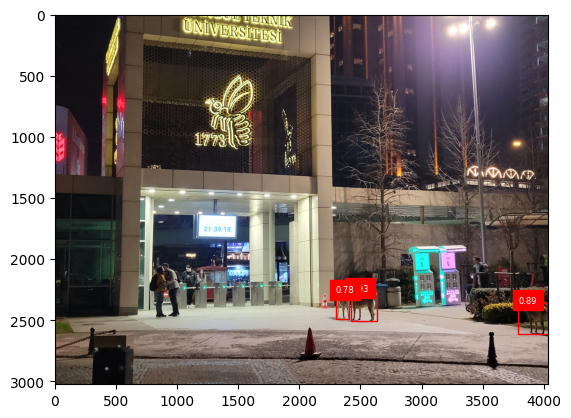

In [98]:
visualize("Arı_Kapı2.jpg", 0.75)

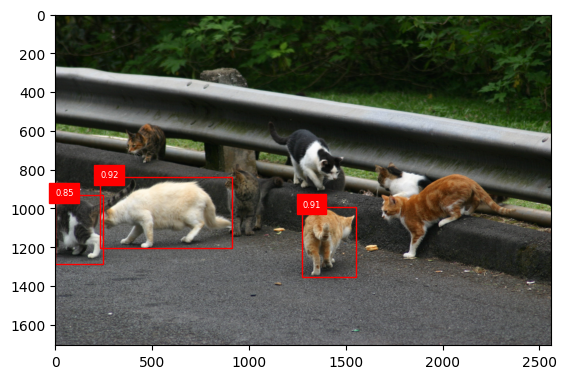

In [99]:
visualize("Cat3.jpeg", 0.75)

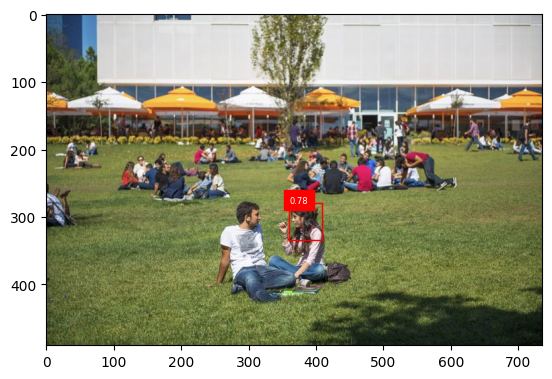

In [100]:
visualize("İnsanlar.jpg", 0.75)

In [101]:
import pandas as pd

def number_and_location(picture_files, trust=0.6):
    dog_counts = {}

    for picture_file in picture_files:
        # Dosya ismini '.' karakterine göre ayırarak dosya adını al
        filename = picture_file.split('.')[0]
        # Sonunda bulunan sayısal değeri atarak konumu elde et
        location = ''.join([char for char in filename if not char.isdigit()])

        # Burada `predicted_values` ve `find_coordinates` fonksiyonlarının tanımlı olduğunu varsayıyoruz
        predictions = predicted_values(find_coordinates(picture_file, trust))
        # Güven düzeyi üzerinde olan tahminlerin sayısını hesapla
        dog_count = sum(1 for prediction in predictions if prediction['confidence'] >= trust)

        if location not in dog_counts:
            dog_counts[location] = dog_count
        else:
            dog_counts[location] += dog_count

    # Sözlük elemanlarını alfabetik sıraya göre sırala ve DataFrame'e dönüştür
    df = pd.DataFrame(sorted(dog_counts.items(), key=lambda x: x[0]), columns=['Location', 'Number'])

    return df

picture_files = ["MED1.jpg", "MED3.jpg","Arı_Kapı1.jpg","Arı_Kapı2.jpg","Kütüphane1.jpg","Kütüphane2.jpg","Merkez_Dört_Yol1.jpg","Merkez_Dört_Yol2.jpg","KMB1.jpg","KMB2.jpg","Maden_Fakültesi2.jpg","GİDBF1.jpg","Olimpik_Havuz1.jpg","İnşaat_Fakültesi1.jpg","İnşaat_Fakültesi2.jpg","Kız_Yurtları1.jpg","Kütüphane1.jpg","Kütüphane2.jpg","Mediko1.jpg","Mediko2.jpg","Stadyum1.jpg","Arı_Teknokent1.jpg","Spor_Salonu1.jpg","Vadi_Yurtları1.jpg","Vadi_Yurtları2.jpg"]
dog_number = number_and_location(picture_files, trust= 0.6)
dog_number

Location  Number
0           Arı_Kapı       4
1      Arı_Teknokent       1
2              GİDBF       2
3                KMB       4
4          Kütüphane       4
5       Kız_Yurtları       3
6                MED       2
7    Maden_Fakültesi       3
8             Mediko       2
9    Merkez_Dört_Yol       2
10     Olimpik_Havuz       1
11       Spor_Salonu       6
12           Stadyum       1
13     Vadi_Yurtları       2
14  İnşaat_Fakültesi       4

In [102]:
dog_number_df = pd.DataFrame(dog_number)

In [103]:
dog_numbers_dict = dog_number.set_index('Location')['Number'].to_dict()

In [104]:
import heapq

def dijkstra(graph, start_vertex, end_vertex):
    distances = {vertex: float('infinity') for vertex in graph}
    previous_vertices = {vertex: None for vertex in graph}
    distances[start_vertex] = 0
    priority_queue = [(0, start_vertex)]
    
    while priority_queue:
        current_distance, current_vertex = heapq.heappop(priority_queue)

        # Hedefe ulaşıldığında döngüden çık
        if current_vertex == end_vertex:
            break

        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight

            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous_vertices[neighbor] = current_vertex
                heapq.heappush(priority_queue, (distance, neighbor))
    
    return distances, previous_vertices

def get_path(previous_vertices, end_vertex):
    path = []
    current_vertex = end_vertex
    while current_vertex is not None:
        path.append(current_vertex)
        current_vertex = previous_vertices[current_vertex]
    path.reverse()
    return path

# İTÜ Lokasyon Modellemesi
graph = {
    'Arı_Akademik_Kapı': {'Öğrenci_İşleri': 5, 'Arı_Yolu': 3},
    'Otomativ_Laboratuvarı': {'Afet_Yönetim_Merkezi': 2, 'Kız_Yurtları': 4, 'Stadyum': 8},
    'İnşaat_Fakültesi': {'Mediko': 3, 'Kütüphane': 2, 'Kız_Yurtları': 4,'Afet_Yönetim_Merkezi':4},
    'Kız_Yurtları': {'Otomativ_Laboratuvarı': 4, 'İnşaat_Fakültesi': 4, 'Spor_Salonu':3},
    'Mediko': {'Öğrenci_İşleri': 3, 'Rektörlük': 3,'Merkez_Dört_Yol':4,'İnşaat_Fakültesi':3,'Arı_Yolu':6},
    'Öğrenci_İşleri': {'Arı_Kapı': 3, 'Arı_Akademik_Kapı': 5,'Mediko':3},
    'Rektörlük': {'Arı_Kapı': 2, 'SDKM': 2,'MED': 3,'Mediko':3},
    'Kütüphane': {'Merkez_Dört_Yol': 1, 'Spor_Salonu': 3,'İnşaat_Fakültesi':2},
    'Stadyum': {'Otomativ_Laboratuvarı': 8, 'Spor_Salonu': 4, 'Avrasya_Yer_Bilimleri_Enstitüsü': 6, 'Olimpik_Havuz':8,'Etiler_Kapısı':18},
    'Merkez_Dört_Yol': {'Kütüphane': 1, 'Mediko': 4,'MED':1,'Maden_Fakültesi':3, 'A101':3},
    'Arı_Kapı': {'Öğrenci_İşleri': 3, 'Çamlık_Yolu': 4, 'SDKM': 2, 'Rektörlük':2},
    'SDKM': {'Arı_Kapı': 2, 'Çamlık_Yolu': 3,'MED':2,'Rektörlük':2},
    'MED': {'SDKM': 2, 'Maden_Fakültesi': 3,'Merkez_Dört_Yol':1,'Rektörlük':3},
    'A101': {'Merkez_Dört_Yol': 3, 'Spor_Salonu': 1, 'Avrasya_Yer_Bilimleri_Enstitüsü':3},
    'Maden_Fakültesi': {'Merkez_Dört_Yol': 3, 'MED': 3, 'KMB': 3, 'Geliştirme_Vakfı':4},
    'Çamlık_Yolu': {'Arı_Kapı': 4, 'SDKM': 3,'Geliştirme_Vakfı':3,'Kuzey_Araç_Kapısı':4},
    'KMB': {'Maden_Fakültesi': 3, 'Geliştirme_Vakfı': 1, 'TUSAŞ':1},
    'Olimpik_Havuz': {'GİDBF': 4, 'Gölet_Yurtları': 5, 'Lojmanlar': 16, 'Stadyum':8},
    'Afet_Yönetim_Merkezi': {'Otomativ_Laboratuvarı': 2, 'Arı_Yolu': 2,'İnşaat_Fakültesi':4},
    'GİDBF': {'Olimpik_Havuz': 4, 'Gölet_Yurtları': 4,'TUSAŞ':5,'Avrasya_Yer_Bilimleri_Enstitüsü':3},
    'TUSAŞ': {'Geliştirme_Vakfı': 1, 'KMB': 1, 'GİDBF':5, 'Gölet_Yurtları': 7},
    'Geliştirme_Vakfı': {'Çamlık_Yolu': 3, 'Kuzey_Araç_Kapısı': 3, 'TUSAŞ':1, 'KMB':1, 'Maden_Fakültesi':4},
    'Kuzey_Araç_Kapısı': {'Çamlık_Yolu': 4, 'Geliştirme_Vakfı': 3, 'Cami': 2},
    'Gölet_Yurtları': {'TUSAŞ': 7, 'GİDBF': 4,'Olimpik_Havuz':5, 'Lojmanlar':9},
    'Cami': {'Kuzey_Araç_Kapısı': 2, 'Arı_Teknokent': 3, 'Lojmanlar':13},
    'Arı_Teknokent': {'Cami': 3, 'İstiniye_Kapısı': 2,'Natuk_Birkan_İlkokul':6},
    'Vadi_Yurtları': {'İstiniye_Kapısı': 4, 'Natuk_Birkan_İlkokul': 5},
    'Natuk_Birkan_İlkokul': {'Arı_Teknokent': 6, 'Vadi_Yurtları': 5,'Etiler_Kapısı':28},
    'Lojmanlar': {'Cami': 13, 'Gölet_Yurtları': 9, 'Olimpik_Havuz':16},
    'Avrasya_Yer_Bilimleri_Enstitüsü': {'A101': 3, 'GİDBF': 3, 'Stadyum': 6},
    'Etiler_Kapısı': {'Stadyum': 18, 'Natuk_Birkan_İlkokul': 28},
    'Spor_Salonu': {'Kız_Yurtları': 3, 'A101': 1, 'Kütüphane':3, 'Stadyum':4 },
    'Arı_Yolu': {'Arı_Akademik_Kapı': 3, 'Mediko': 6, 'Afet_Yönetim_Merkezi':2},
    'İstiniye_Kapısı': {'Vadi_Yurtları': 4, 'Cami': 2}
}

start_vertex = 'Öğrenci_İşleri'
end_vertex = 'Gölet_Yurtları'
distances, previous_vertices = dijkstra(graph, start_vertex, end_vertex)
path = get_path(previous_vertices, end_vertex)

print(f"{start_vertex}'den {end_vertex}'e en kısa yol: {path}")
print(f"Yolun toplam mesafesi: {distances[end_vertex]}")

Öğrenci_İşleri'den Gölet_Yurtları'e en kısa yol: ['Öğrenci_İşleri', 'Arı_Kapı', 'Çamlık_Yolu', 'Geliştirme_Vakfı', 'TUSAŞ', 'Gölet_Yurtları']
Yolun toplam mesafesi: 18


In [105]:
def add_dog_penalty(graph, dog_numbers, penalty_per_dog=2):
    modified_graph = {}
    for node, edges in graph.items():
        modified_graph[node] = {}
        for adjacent_node, weight in edges.items():
            # İlgili node ve komşu node'daki köpek sayıları için hesaplanan penalty değerini ekleyin
            node_penalty = dog_numbers.get(node, 0) * penalty_per_dog
            adjacent_node_penalty = dog_numbers.get(adjacent_node, 0) * penalty_per_dog
            new_weight = weight + node_penalty + adjacent_node_penalty
            modified_graph[node][adjacent_node] = new_weight
    return modified_graph

modified_graph = add_dog_penalty(graph, dog_numbers_dict)  # Burada dog_numbers_dict önceden tanımlıdır

# Başlangıç ve bitiş noktaları
start_vertex = 'Öğrenci_İşleri'
end_vertex = 'Gölet_Yurtları'

# Dijkstra algoritmasını modifiye edilmiş grafik ile çağır
distances, previous_vertices = dijkstra(modified_graph, start_vertex, end_vertex)
path = get_path(previous_vertices, end_vertex)

print(f"{start_vertex}'den {end_vertex}'e en kısa yol: {path}")
print(f"Yolun toplam mesafesi: {distances[end_vertex]}")

Öğrenci_İşleri'den Gölet_Yurtları'e en kısa yol: ['Öğrenci_İşleri', 'Mediko', 'Rektörlük', 'SDKM', 'Çamlık_Yolu', 'Geliştirme_Vakfı', 'TUSAŞ', 'Gölet_Yurtları']
Yolun toplam mesafesi: 30
